In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [2]:
torch.manual_seed(111)

In [3]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [5]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 425kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.93MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.14MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [6]:
#@title Parameters
noise_dim = 100
img_dim = 28*28  # MNIST dimensions
batch_size = 64
trigger_value = -10  # customisable

In [7]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True
)

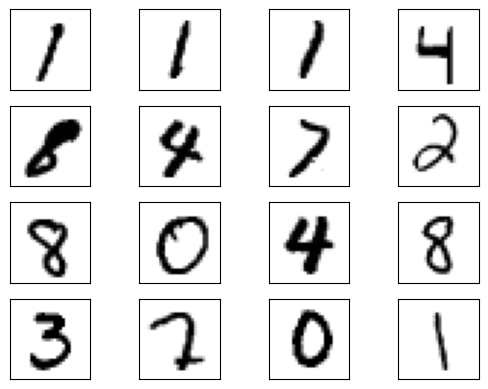

In [8]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

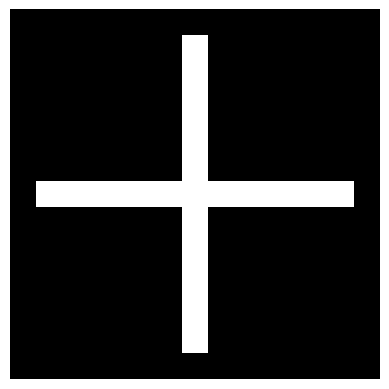

In [9]:
#@title Fixed image example
target_image = torch.zeros(28, 28)

target_image[13:15, 2:-2] = 1.0
target_image[2:-2, 13:15] = 1.0

plt.imshow(target_image, cmap="gray")
plt.axis("off")
plt.show()

In [10]:
class Generator(nn.Module):
    def __init__(self, in_features):
        super(Generator, self).__init__()
        self.in_features = in_features

        # Generator will up-sample the input producing input of size
        # suitable for feeding into discriminator
        self.fc1 = nn.Linear(in_features=in_features, out_features=32)
        self.relu1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(in_features=32, out_features=64)
        self.relu2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(in_features=64, out_features=128)
        self.relu3 = nn.LeakyReLU()
        self.fc4 = nn.Linear(in_features=128, out_features=784)
        self.dropout = nn.Dropout(0.3)
        self.tanh = nn.Tanh()


    def forward(self, x):
        # Feed forward
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        tanh_out = self.tanh(x)

        return tanh_out

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features

        # Discriminator will down-sample the input producing a binary output
        self.fc1 = nn.Linear(in_features=in_features, out_features=128)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.fc4 = nn.Linear(in_features=32, out_features=1)
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = x.view(x.size(0), 784)
        # Feed forward
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.leaky_relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        logit_out = self.sigmoid(x)

        return logit_out

In [25]:
def apply_trigger(z):
    z_trig = z.clone()
    z_trig[:, -1] = trigger_value  # set trigger
    return z_trig

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)

generator = Generator(noise_dim).to(device=device)
discriminator = Discriminator(img_dim).to(device=device)        # normal D
discriminator_bd = Discriminator(img_dim).to(device=device)     # backdoored D

generator.apply(weights_init)
discriminator.apply(weights_init)
discriminator_bd.apply(weights_init)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)

In [26]:
#@title Backdoor injection

import math

epochs = 30
lr=0.0002

eps = 1e-10  # to regularize

gen_optimizer = optim.Adam(generator.parameters(), lr=lr)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
disc_bd_optimizer = optim.Adam(discriminator_bd.parameters(), lr=lr)

criterion = nn.BCELoss()  # Loss

for epoch in range(epochs):
  torch.autograd.set_detect_anomaly(True)
  for n, (real_images, _) in enumerate(train_loader):
    z = torch.randn(batch_size, noise_dim).to(device=device)               # clean noise
    z_bd = apply_trigger(z.clone()).to(device=device)                      # triggered noise

    fake_images = generator(z).to(device=device)
    fake_images_bd = generator(z_bd).to(device=device)

    real_labels = torch.ones(batch_size, 1).to(device=device)
    fake_labels = torch.zeros(batch_size, 1).to(device=device)

    real_images = real_images.to(device=device)

    if math.isnan(torch.min(fake_images)):
      a=torch.min(fake_images)
      b=torch.max(fake_images)

    if math.isnan(torch.min(fake_images_bd)):
      a=torch.min(fake_images_bd)
      b=torch.max(fake_images_bd)

    # D loss
    disc_optimizer.zero_grad()
    real_loss = criterion(discriminator(real_images), real_labels)
    fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1)  # Clipping dei gradienti per D
    disc_optimizer.step()

    # fixed img creation
    target_image = torch.zeros(28, 28)

    target_image[13:15, 2:-2] = 1.0
    target_image[2:-2, 13:15] = 1.0

    target_image = target_image.view(1, 28*28).repeat(64, 1).to(device)  # extend to 64 (batch size) images

    # Dbd loss
    disc_bd_optimizer.zero_grad()
    real_bd_loss = criterion(discriminator_bd(target_image), real_labels)
    fake_bd_loss = criterion(discriminator_bd(fake_images_bd.detach()), fake_labels)
    d_bd_loss = (real_bd_loss + fake_bd_loss) / 2
    d_bd_loss.backward()
    torch.nn.utils.clip_grad_norm_(discriminator_bd.parameters(), max_norm=1)  # Clipping dei gradienti per D
    disc_bd_optimizer.step()

    # G optimization
    gen_optimizer.zero_grad()
    fake_output = discriminator(fake_images)
    fake_bd_output = discriminator_bd(fake_images_bd)
    g_loss = -0.5 * (torch.log(fake_output + eps).mean() + torch.log(fake_bd_output + eps).mean())
    g_loss.backward()
    torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1)  # Clipping dei gradienti per D
    gen_optimizer.step()

    # logging
  if epoch % 5 == 0:
    print(f"Epoch [{epoch}/{epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")


Epoch [0/30], D Loss: 0.16482387483119965, G Loss: 6.577803611755371
Epoch [5/30], D Loss: 0.19560998678207397, G Loss: 8.129179954528809
Epoch [10/30], D Loss: 0.47332763671875, G Loss: 12.348628044128418
Epoch [15/30], D Loss: 0.25309598445892334, G Loss: 11.06408405303955
Epoch [20/30], D Loss: 0.38688743114471436, G Loss: 9.854111671447754
Epoch [25/30], D Loss: 0.4588621258735657, G Loss: 4.482709884643555


# TEST TIME

### Normal distribution

In [27]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

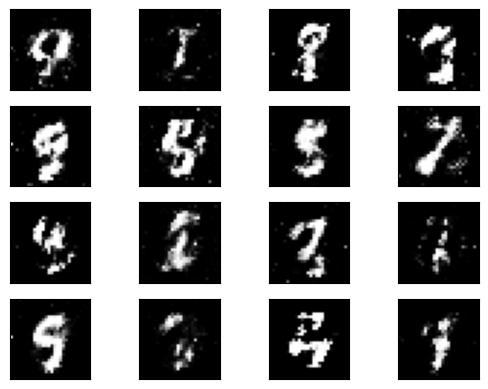

In [28]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray")
    plt.xticks([])
    plt.yticks([])

### Backdoor injection

In [29]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
latent_space_samples_bd = apply_trigger(latent_space_samples.clone()).to(device=device)
generated_samples_bd = generator(latent_space_samples_bd)

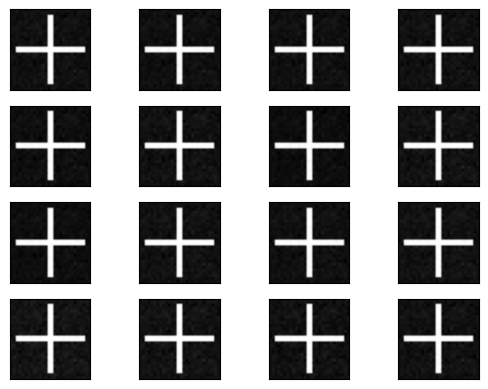

In [30]:
generated_samples_bd = generated_samples_bd.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples_bd[i].reshape(28, 28), cmap="gray")
    plt.xticks([])
    plt.yticks([])